In [ ]:
# Business Questions
# Which sectors within the S&P 500 exhibit higher overall Altman Z-Scores, indicating stronger financial health?
# How does market capitalization influence Altman Z-Scores within different sectors of the S&P 500?
# Datasource: YahooFinance

In [ ]:
# Altman_Z_Score = (1.2*(A)) + (1.4*(B)) + (3.3*(C)) + (0.6*(D)) + (1.0*(E))
# A = Working Capital(Current Assets - Current Liabilites) / Total Assets
# B = Retained Earnings / Total Assets
# C = Earnings Before Interest & Tax(EBIT) / Total Assets
# D = Market Capitalization / Total Liabilities(Total Liabilities Net Minority Interest + Current Liabilities)
# E = Revenue / Total Assets

In [3]:
# Imports
import pandas as pd
import time
import yfinance as yf

# Function to fetch Altman Z-Score and related information for a single stock
def calculate_altman_z_score(ticker):
    """
    Calculate Altman Z-Score for a single stock and fetch sector and market capitalization.

    Parameters:
        ticker (str): Stock ticker symbol.

    Returns:
        tuple: Altman Z-Score (float or None), sector (str), market capitalization (float or None).
    """
    try:
        stock = yf.Ticker(ticker)
        balance_sheet = stock.balance_sheet.T
        financials = stock.financials.T

        # Fetch stock information
        market_cap = stock.info.get('marketCap', None)
        sector = stock.info.get('sector', 'N/A')

        # Extract financial metrics for Altman Z-Score calculation
        try:
            total_assets = balance_sheet['Total Assets'].iloc[0]
            A = (balance_sheet['Current Assets'].iloc[0] - balance_sheet['Current Liabilities'].iloc[0]) / total_assets
            B = balance_sheet['Retained Earnings'].iloc[0] / total_assets
            EBIT = financials['EBIT'].iloc[0]
            C = EBIT / total_assets
            revenue = financials['Total Revenue'].iloc[0]
            E = revenue / total_assets

            total_liabilities = (balance_sheet['Total Liabilities Net Minority Interest'].iloc[0] +
                                 balance_sheet['Current Liabilities'].iloc[0])
            D = market_cap / total_liabilities if market_cap else None

            # Calculate Altman Z-Score
            z_score = (1.2 * A) + (1.4 * B) + (3.3 * C) + (0.6 * D) + (1.0 * E)
        except Exception as e:
            print(f"Error calculating financial metrics for {ticker}: {e}")
            z_score = None

        return z_score, sector, market_cap

    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return None, 'N/A', None

# Function to categorize Altman Z-Score into safety levels
def categorize_z_score(z_score):
    """
    Categorize stocks based on Altman Z-Score.

    Parameters:
        z_score (float or None): Altman Z-Score.

    Returns:
        str: Safety category ('Safe', 'Gray', 'Distress', or 'N/A').
    """
    if z_score is None:
        return 'N/A'
    elif z_score >= 3.0:
        return 'Safe'
    elif z_score >= 1.8:
        return 'Gray'
    else:
        return 'Distress'

# Function to scale market capitalization to billions
def scale_market_cap(market_cap):
    """
    Scale market capitalization to billions.

    Parameters:
        market_cap (float or None): Market capitalization in raw units.

    Returns:
        float or str: Market cap in billions or 'N/A' if invalid.
    """
    if market_cap is None:
        return 'N/A'
    try:
        return round(market_cap / 1e9, 2)
    except Exception:
        return 'N/A'

In [ ]:
# Fetch S&P 500 tickers and perform calculations
tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]['Symbol'].to_list()

# Lists to store results
altman_scores = []
sectors = []
market_caps = []

# Iterate over all tickers and calculate metrics
for ticker in tickers:
    z_score, sector, market_cap = calculate_altman_z_score(ticker)
    altman_scores.append(z_score)
    sectors.append(sector)
    market_caps.append(market_cap)
    # Respect API rate limits
    time.sleep(30)

# Create DataFrame with results
df = pd.DataFrame({'Ticker': tickers})
df['Altman Z-Score'] = altman_scores
df['Safety Level'] = df['Altman Z-Score'].apply(categorize_z_score)
df['Sector'] = sectors
df['Market Cap'] = market_caps
df['Market Cap (Billions)'] = df['Market Cap'].apply(scale_market_cap)

In [11]:
# Identify rows with NaN or null values
#nan_rows = df[df.isnull().any(axis=1)]

# Display the tickers and the corresponding rows with NaN or null values
#if not nan_rows.empty:
#    print("Tickers with NaN or null values and their rows of information:")
#    print(nan_rows)
#else:
#    print("No rows with NaN or null values found.")

# Dataframe length before removal
print(f'Dataframe length before removal: {len(df)}')

# Remove rows with NaN or null values
df = df.dropna()

# Dataframe length after removal
print(f'Dataframe length after removal: {len(df)}')

Dataframe length before removal: 503
Dataframe length after removal: 444


In [ ]:
# Export results to a CSV file
df.to_csv("AltmanZ_Score_Analysis.csv", index=False)

In [22]:
# Display a sample of the results
print(df.head())

  Ticker  Altman Z-Score Safety Level       Sector    Market Cap  \
0    MMM        1.853680         Gray  Industrials  7.271496e+10   
1    AOS        6.390297         Safe  Industrials  1.080068e+10   
2    ABT        4.302581         Safe   Healthcare  2.060018e+11   
3   ABBV        1.753433     Distress   Healthcare  3.232629e+11   
4    ACN        5.324328         Safe   Technology  2.264291e+11   

   Market Cap (Billions)  
0                  72.71  
1                  10.80  
2                 206.00  
3                 323.26  
4                 226.43  


In [45]:
# Visual Importsa
import matplotlib.pyplot as plt
import seaborn as sns

#Additonal Imports
%pip install adjustText
from adjustText import adjust_text

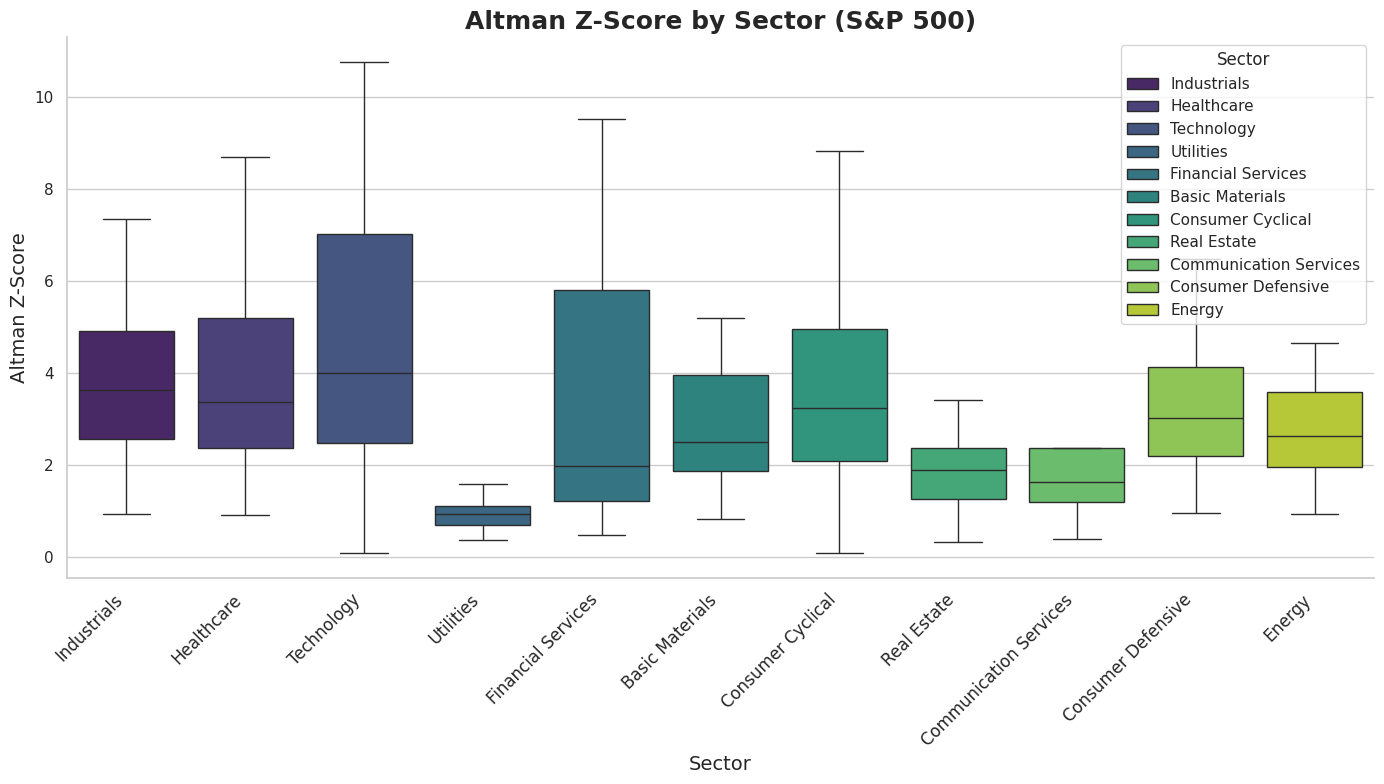

In [21]:
# Altman Z-Score by Sector
plt.figure(figsize=(14, 8))
sns.boxplot(data=df, x='Sector', y='Altman Z-Score', hue='Sector', palette='viridis', showfliers=False, dodge=False)
sns.despine()

# Add title and labels
plt.title("Altman Z-Score by Sector (S&P 500)", fontsize=18, weight='bold')
plt.xlabel("Sector", fontsize=14)
plt.ylabel("Altman Z-Score", fontsize=14)
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.tight_layout()

plt.show()

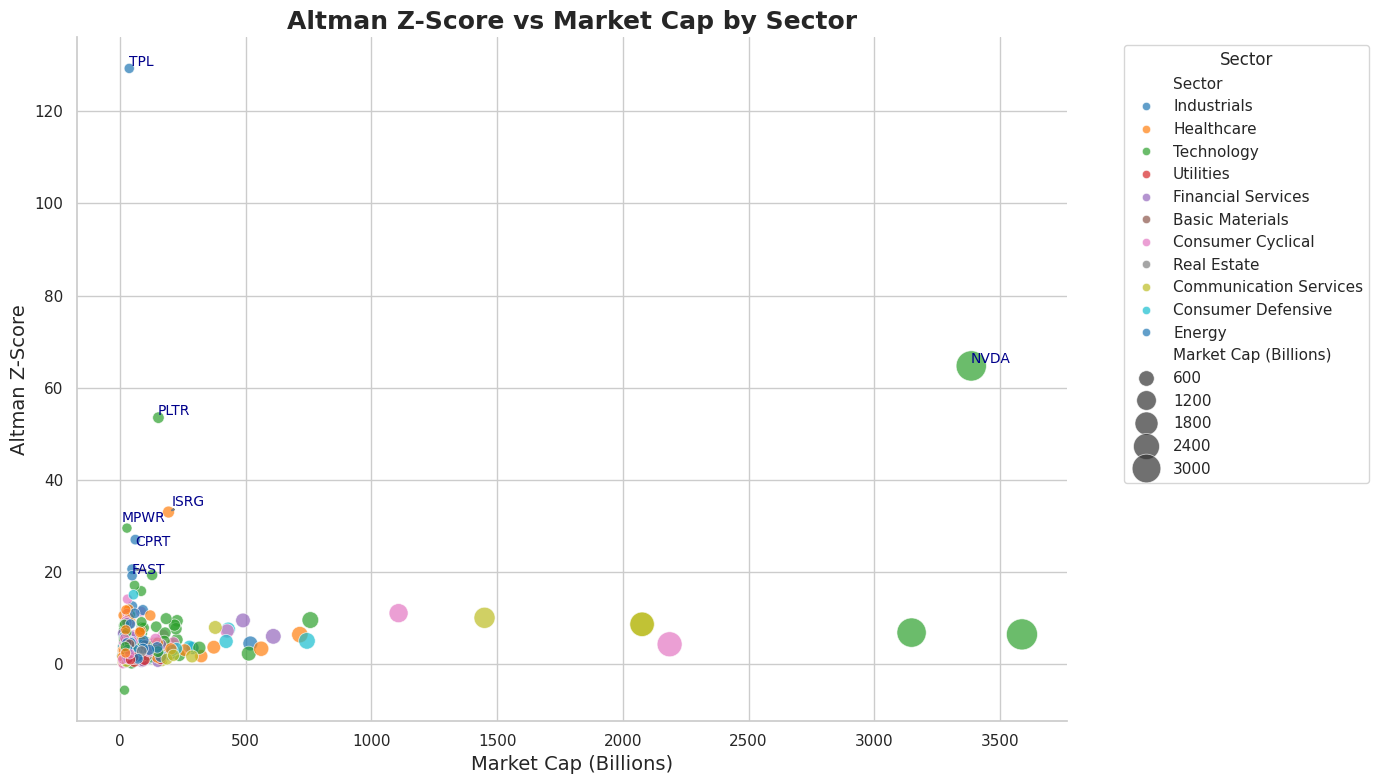

In [18]:
# Scatter plot for Altman Z-Score vs Market Cap
plt.figure(figsize=(14, 8))
scatter = sns.scatterplot(
    data=df,
    x='Market Cap (Billions)',
    y='Altman Z-Score',
    hue='Sector',
    size='Market Cap (Billions)',
    sizes=(50, 500),
    alpha=0.7,
    palette='tab10'
)

# Customize plot
plt.title("Altman Z-Score vs Market Cap by Sector", fontsize=18, weight='bold')
plt.xlabel("Market Cap (Billions)", fontsize=14)
plt.ylabel("Altman Z-Score", fontsize=14)
plt.legend(title="Sector", bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine()

# Identify outliers dynamically (2 standard deviations above the mean)
threshold = df['Altman Z-Score'].mean() + 2 * df['Altman Z-Score'].std()
outliers = df[df['Altman Z-Score'] > threshold]

# Annotate outliers
texts = []
for _, row in outliers.iterrows():
    texts.append(
        plt.text(
            row['Market Cap (Billions)'], row['Altman Z-Score'],
            f"{row['Ticker']}", fontsize=10, color='darkblue'
        )
    )

# Adjust text to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='gray', lw=1.5))

# Finalize layout
plt.tight_layout()
plt.show()

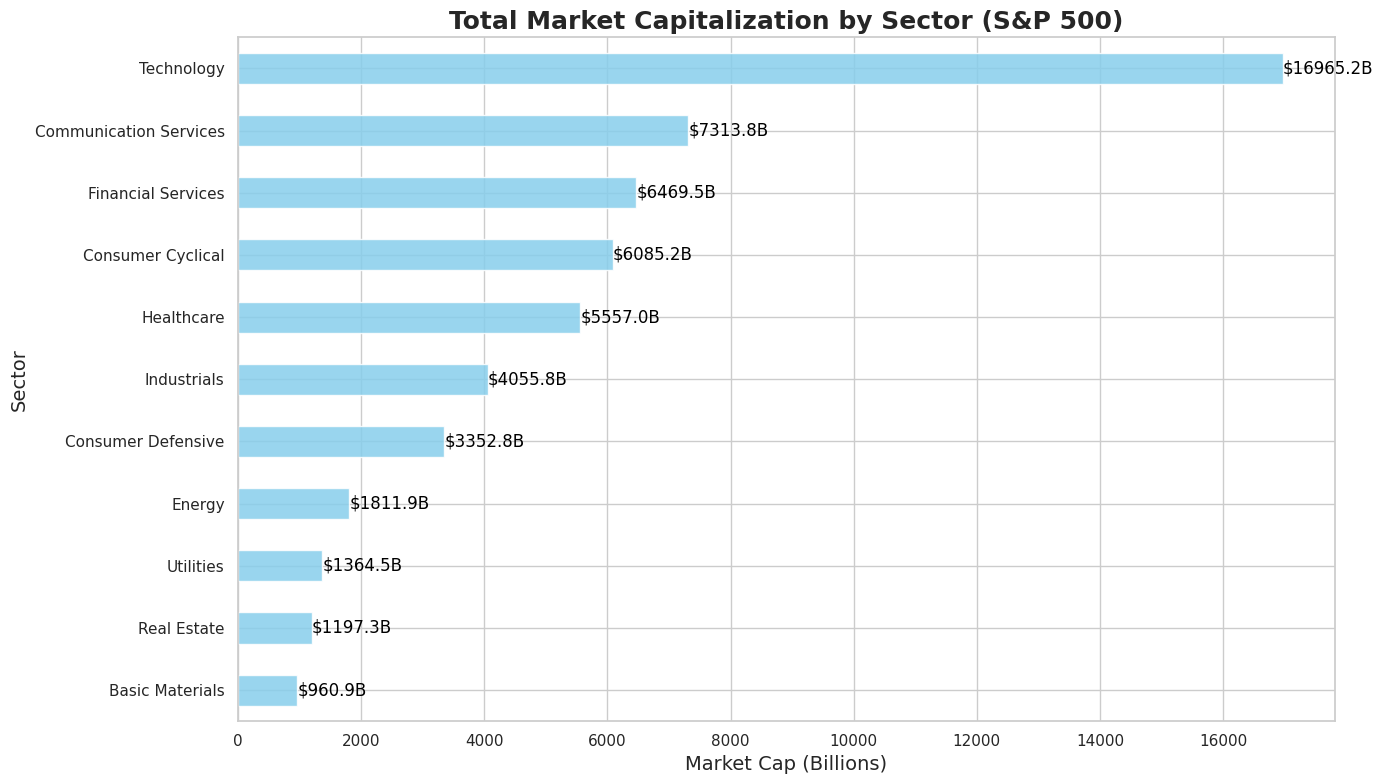

In [14]:
# Group data by sector for market cap distribution
sector_market_cap = df.groupby('Sector')['Market Cap (Billions)'].sum().sort_values()

# Stacked bar chart for market cap distribution
plt.figure(figsize=(14, 8))
sector_market_cap.plot(kind='barh', color='skyblue', alpha=0.85)

# Add titles and labels
plt.title("Total Market Capitalization by Sector (S&P 500)", fontsize=18, weight='bold')
plt.xlabel("Market Cap (Billions)", fontsize=14)
plt.ylabel("Sector", fontsize=14)

# Annotate values on bars
for i, v in enumerate(sector_market_cap):
    plt.text(v + 5, i, f"${v:.1f}B", color='black', va='center', fontsize=12)

plt.tight_layout()
plt.show()

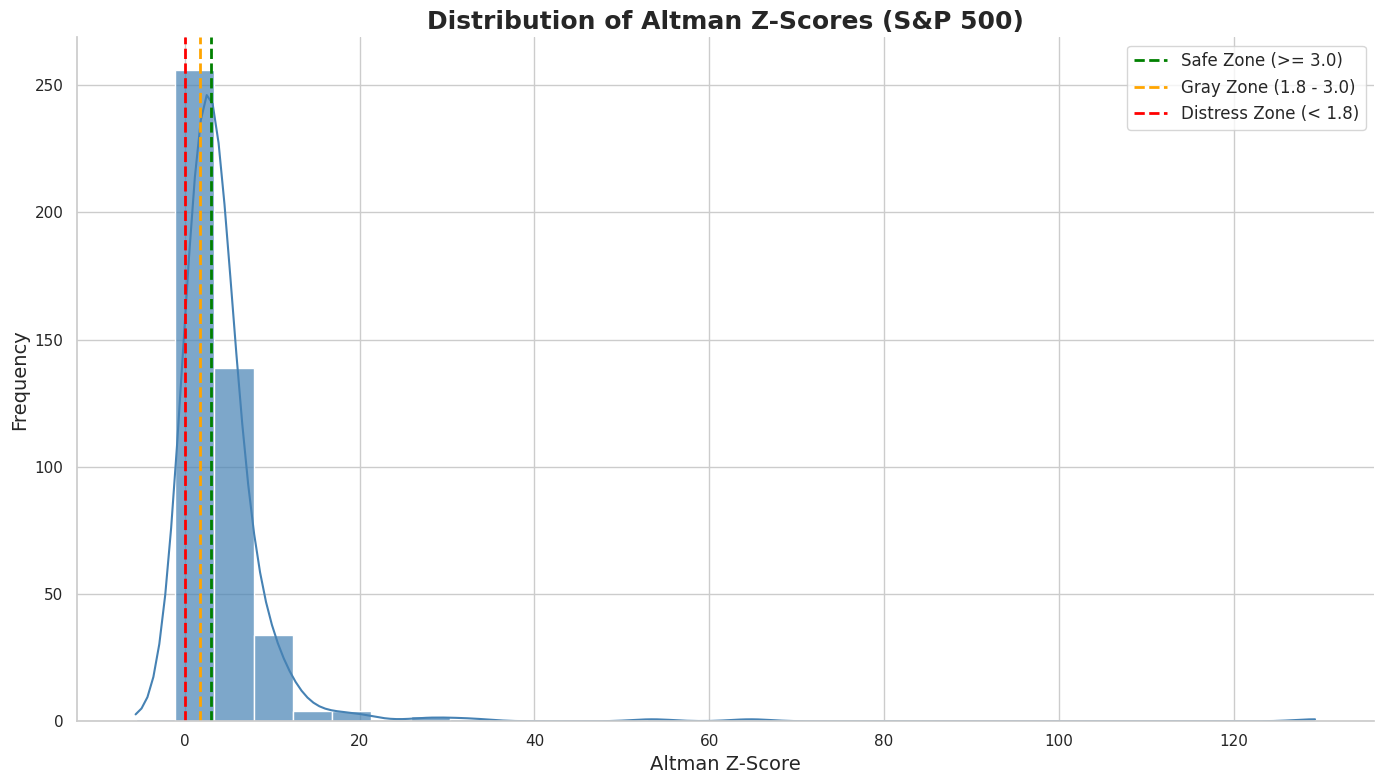

In [12]:
# Histogram with KDE for Altman Z-Score distribution
plt.figure(figsize=(14, 8))
sns.histplot(df['Altman Z-Score'], kde=True, bins=30, color='steelblue', alpha=0.7)

# Customize plot
plt.title("Distribution of Altman Z-Scores (S&P 500)", fontsize=18, weight='bold')
plt.xlabel("Altman Z-Score", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
sns.despine()

# Add vertical lines for key thresholds
plt.axvline(3.0, color='green', linestyle='--', linewidth=2, label='Safe Zone (>= 3.0)')
plt.axvline(1.8, color='orange', linestyle='--', linewidth=2, label='Gray Zone (1.8 - 3.0)')
plt.axvline(0.0, color='red', linestyle='--', linewidth=2, label='Distress Zone (< 1.8)')

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

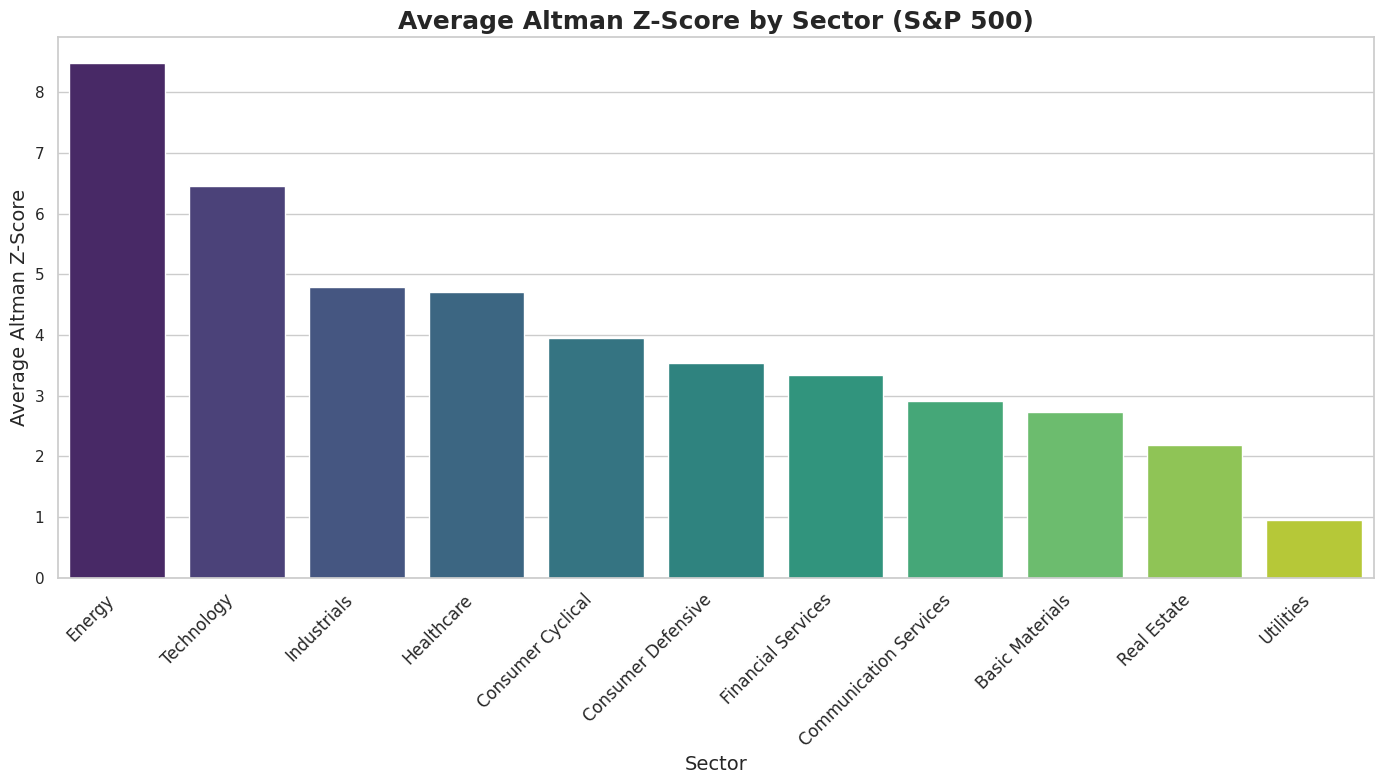

In [26]:
# Average Altman Z-Score by Sector
plt.figure(figsize=(14, 8))
avg_z_score_by_sector = df.groupby('Sector')['Altman Z-Score'].mean().sort_values(ascending=False)
sns.barplot(x=avg_z_score_by_sector.index, y=avg_z_score_by_sector.values, hue=avg_z_score_by_sector.index, palette='viridis', legend=False)

# Add title and labels
plt.title("Average Altman Z-Score by Sector (S&P 500)", fontsize=18, weight='bold')
plt.xlabel("Sector", fontsize=14)
plt.ylabel("Average Altman Z-Score", fontsize=14)
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.tight_layout()

plt.show()

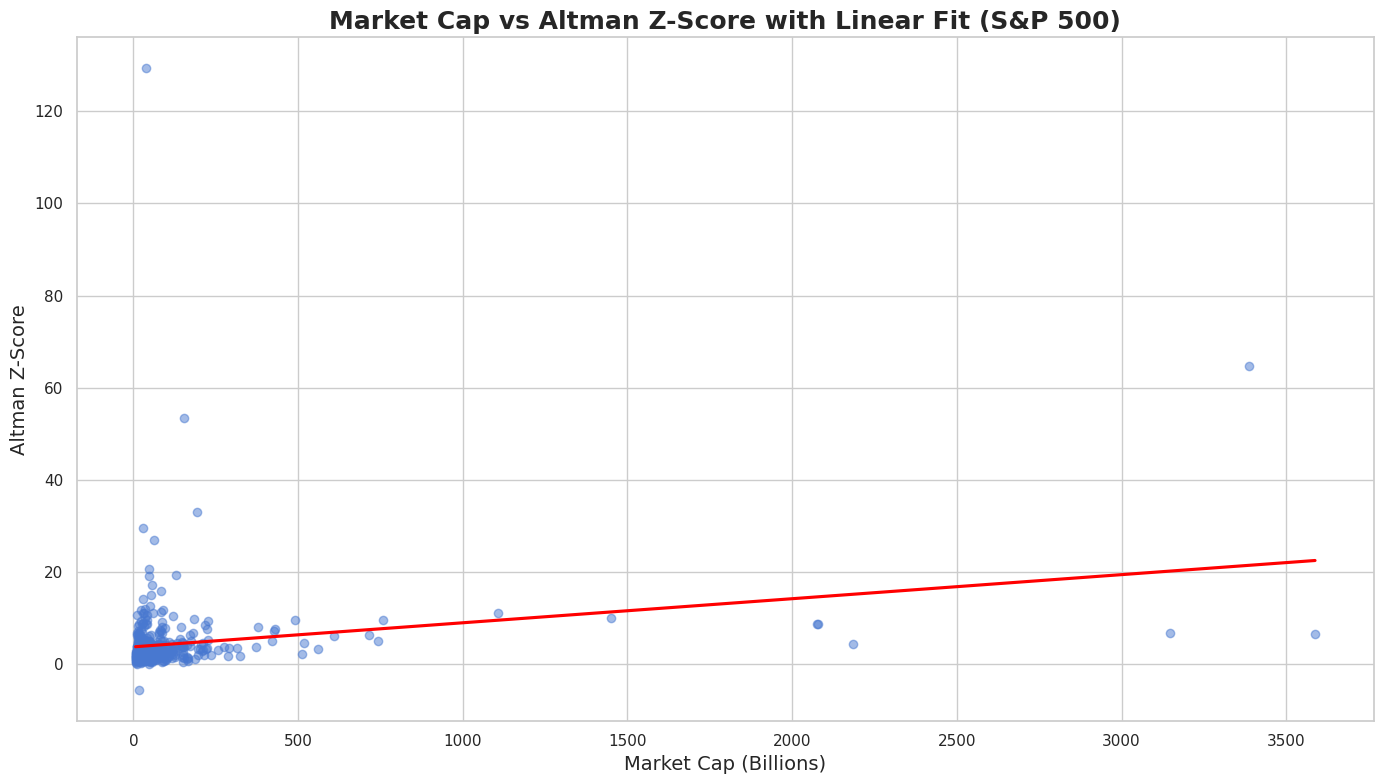

In [28]:
# Scatter plot: Market Cap vs Altman Z-Score with linear fit
plt.figure(figsize=(14, 8))
sns.regplot(data=df, x='Market Cap (Billions)', y='Altman Z-Score', scatter_kws={'alpha':0.5}, line_kws={'color':'red'}, ci=None)

# Add title and labels
plt.title("Market Cap vs Altman Z-Score with Linear Fit (S&P 500)", fontsize=18, weight='bold')
plt.xlabel("Market Cap (Billions)", fontsize=14)
plt.ylabel("Altman Z-Score", fontsize=14)
plt.tight_layout()

plt.show()

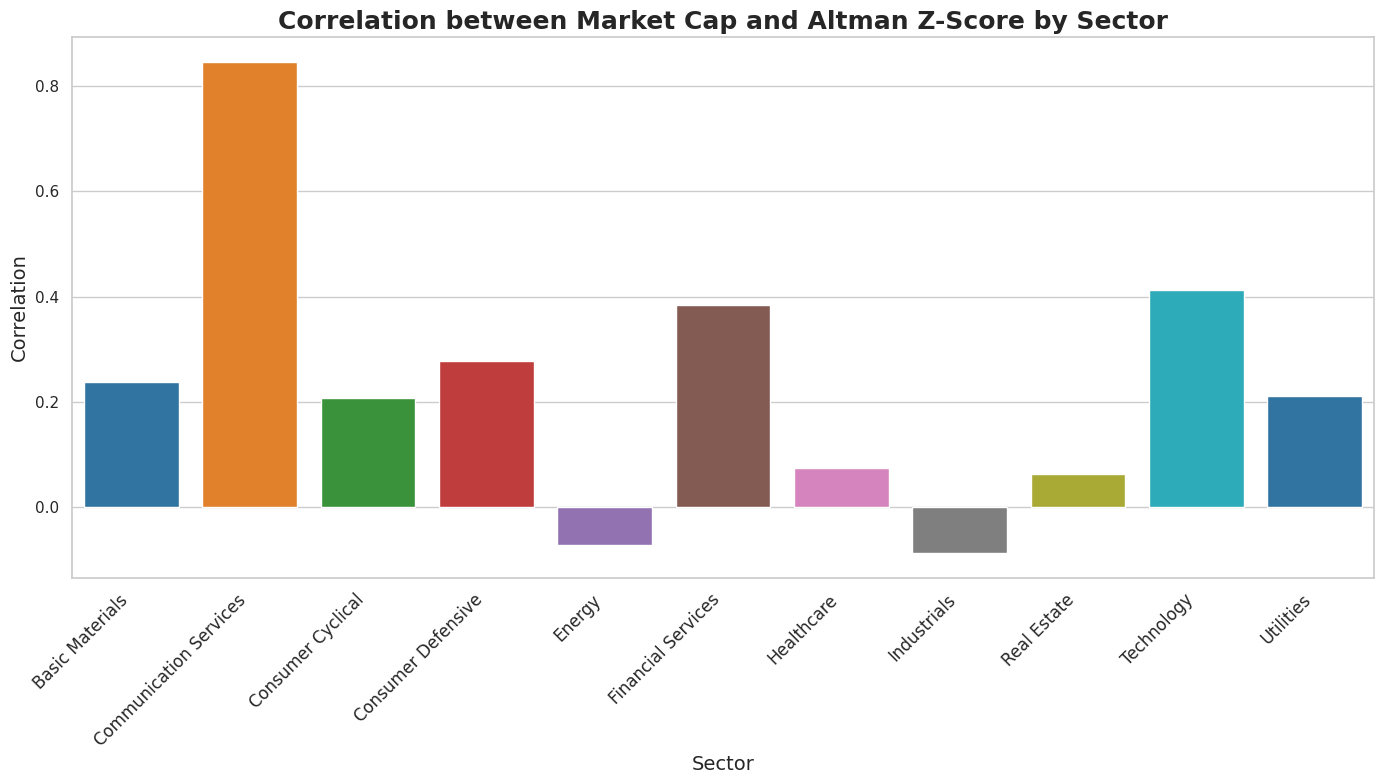

In [43]:
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

# Calculate correlation between Market Cap and Altman Z-Score for each sector
correlation_by_sector = df.groupby('Sector').apply(
    lambda x: x[['Market Cap (Billions)', 'Altman Z-Score']].corr().iloc[0, 1]
).reset_index(name='Correlation')

# Remove unnecessary multi-index (only one index is needed for sectors)
correlation_by_sector = correlation_by_sector[['Sector', 'Correlation']]

# Set custom color palette (use distinct colors for sectors)
palette = sns.color_palette("tab10", len(correlation_by_sector))  # Use distinct colors for sectors

# Create a bar plot for the correlation values by sector
plt.figure(figsize=(14, 8))

# Plot the barplot with custom colors for each sector (no hue, directly using palette)
sns.barplot(x='Sector', y='Correlation', data=correlation_by_sector, palette=palette)

# Add title and labels
plt.title("Correlation between Market Cap and Altman Z-Score by Sector", fontsize=18, weight='bold')
plt.xlabel("Sector", fontsize=14)
plt.ylabel("Correlation", fontsize=14)
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.tight_layout()

plt.show()

# Reset warnings filter after the plot
warnings.filterwarnings('default')